In [2]:
import gdown

url = "https://drive.google.com/file/d/1--0DjoXkxZ2zN1t8_9XWc9gUySo2QGgA/view?usp=sharing"

file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id)
print("Data downloaded!")

1--0DjoXkxZ2zN1t8_9XWc9gUySo2QGgA


Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1--0DjoXkxZ2zN1t8_9XWc9gUySo2QGgA
From (redirected): https://drive.google.com/uc?/export=download&id=1--0DjoXkxZ2zN1t8_9XWc9gUySo2QGgA&confirm=t&uuid=f6f28fb7-c530-4334-9695-209459eddd01
To: d:\model\food-101.tar.gz
100%|██████████| 5.00G/5.00G [17:56<00:00, 4.64MB/s]

Data downloaded!


In [6]:
# Cell 2: Extract Dataset
import tarfile
import os

# Path to the uploaded tar file
tar_path = '/model/food-101.tar.gz'  # Update this path as per your Drive structure
output_path = '/model/data'

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Extract the tar file
with tarfile.open(tar_path, 'r:gz') as tar_ref:
    tar_ref.extractall(output_path)

print("Data extracted to:", output_path)

Data extracted to: /model/data


In [7]:
# Cell 3: Prepare YOLO Dataset (Subset and Labeling)
import os
import random
import shutil
from pathlib import Path

def create_dirs(path):
    """Create directory if it doesn't exist"""
    os.makedirs(path, exist_ok=True)

def create_yolo_label(image_path, class_id, output_dir):
    """Create YOLO label file with centered bounding box"""
    # Get image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(output_dir, f"{image_name}.txt")

    # Create centered bounding box
    x_center = 0.5
    y_center = 0.5
    bbox_width = 1.0
    bbox_height = 1.0

    # Write label file
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

def prepare_yolo_dataset(dataset_path, output_base_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, subset_size=500):
    """
    Prepare dataset for YOLO training by:
    1. Creating a subset of the dataset (e.g., 500 images per class).
    2. Splitting the subset into train/val/test.
    3. Creating labels for the subset.
    """

    # Create output directories
    splits = ['train', 'val', 'test']
    for split in splits:
        create_dirs(os.path.join(output_base_path, 'images', split))
        create_dirs(os.path.join(output_base_path, 'labels', split))

    # Get class directories and create class mapping
    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(class_dirs))}

    # Save class mapping
    with open(os.path.join(output_base_path, 'classes.txt'), 'w') as f:
        for class_name in sorted(class_dirs):
            f.write(f"{class_name}\n")

    # Process each class
    for class_name in class_dirs:
        class_path = os.path.join(dataset_path, class_name)
        class_id = class_mapping[class_name]

        # Get all images in class directory
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)

        # Create a subset of images (e.g., 500 images per class)
        if subset_size > 0:
            images = images[:subset_size]  # Take the first `subset_size` images

        # Calculate split sizes
        n_images = len(images)
        n_train = int(n_images * train_ratio)
        n_val = int(n_images * val_ratio)

        # Split images into train/val/test
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]

        # Process each split
        splits_data = {
            'train': train_images,
            'val': val_images,
            'test': test_images
        }

        for split, split_images in splits_data.items():
            for image_name in split_images:
                # Copy image
                src_path = os.path.join(class_path, image_name)
                dst_path = os.path.join(output_base_path, 'images', split, image_name)
                shutil.copy2(src_path, dst_path)

                # Create label
                create_yolo_label(dst_path, class_id,
                                os.path.join(output_base_path, 'labels', split))

if __name__ == "__main__":
    # Define paths
    dataset_path = '/kaggle/working/data/food-101/images'  # Path to your dataset
    output_base_path = '/kaggle/working/yolo_subset_dataset'  # Path to save subset dataset

    # Set random seed for reproducibility
    random.seed(42)

    # Process dataset (create subset and labels)
    prepare_yolo_dataset(dataset_path, output_base_path, subset_size=500)  # 500 images per class

    print("Subset dataset preparation completed!")
    print(f"Output directory structure:")
    print(f"- {output_base_path}/")
    print(f"  ├── images/")
    print(f"  │   ├── train/")
    print(f"  │   ├── val/")
    print(f"  │   └── test/")
    print(f"  ├── labels/")
    print(f"  │   ├── train/")
    print(f"  │   ├── val/")
    print(f"  │   └── test/")
    print(f"  └── classes.txt")

Subset dataset preparation completed!
Output directory structure:
- /kaggle/working/yolo_subset_dataset/
  ├── images/
  │   ├── train/
  │   ├── val/
  │   └── test/
  ├── labels/
  │   ├── train/
  │   ├── val/
  │   └── test/
  └── classes.txt


In [8]:
import os
import random
import shutil
from pathlib import Path

def create_dirs(path):
    """Create directory if it doesn't exist"""
    os.makedirs(path, exist_ok=True)

def create_yolo_label(image_path, class_id, output_dir):
    """Create YOLO label file with centered bounding box"""
    # Get image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(output_dir, f"{image_name}.txt")

    # Create centered bounding box
    x_center = 0.5
    y_center = 0.5
    bbox_width = 1.0
    bbox_height = 1.0

    # Write label file
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

def prepare_yolo_dataset(dataset_path, output_base_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Prepare dataset for YOLO training by splitting data and creating labels"""

    # Create output directories
    splits = ['train', 'val', 'test']
    for split in splits:
        create_dirs(os.path.join(output_base_path, 'images', split))
        create_dirs(os.path.join(output_base_path, 'labels', split))

    # Get class directories and create class mapping
    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(class_dirs))}

    # Save class mapping
    with open(os.path.join(output_base_path, 'classes.txt'), 'w') as f:
        for class_name in sorted(class_dirs):
            f.write(f"{class_name}\n")

    # Process each class
    for class_name in class_dirs:
        class_path = os.path.join(dataset_path, class_name)
        class_id = class_mapping[class_name]

        # Get all images in class directory
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)

        # Calculate split sizes
        n_images = len(images)
        n_train = int(n_images * train_ratio)
        n_val = int(n_images * val_ratio)

        # Split images into train/val/test
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]

        # Process each split
        splits_data = {
            'train': train_images,
            'val': val_images,
            'test': test_images
        }

        for split, split_images in splits_data.items():
            for image_name in split_images:
                # Copy image
                src_path = os.path.join(class_path, image_name)
                dst_path = os.path.join(output_base_path, 'images', split, image_name)
                shutil.copy2(src_path, dst_path)

                # Create label
                create_yolo_label(dst_path, class_id,
                                os.path.join(output_base_path, 'labels', split))

if __name__ == "__main__":
    # Define paths
    dataset_path = '/kaggle/working/data/food-101/images'  # Path to your dataset
    output_base_path = '/kaggle/working/data/food-101/yolo_dataset'  # Path to save processed data

    # Set random seed for reproducibility
    random.seed(42)

    # Process dataset
    prepare_yolo_dataset(dataset_path, output_base_path)

    print("Dataset preparation completed!")
    print(f"Output directory structure:")
    print(f"- {output_base_path}/")
    print(f"  ├── images/")
    print(f"  │   ├── train/")
    print(f"  │   ├── val/")
    print(f"  │   └── test/")
    print(f"  ├── labels/")
    print(f"  │   ├── train/")
    print(f"  │   ├── val/")
    print(f"  │   └── test/")
    print(f"  └── classes.txt")

Dataset preparation completed!
Output directory structure:
- /kaggle/working/data/food-101/yolo_dataset/
  ├── images/
  │   ├── train/
  │   ├── val/
  │   └── test/
  ├── labels/
  │   ├── train/
  │   ├── val/
  │   └── test/
  └── classes.txt


In [1]:
# Cell 5: Create data.yaml for Subset Dataset
import os
import yaml

def create_data_yaml(dataset_path, output_path, yaml_path):
    """
    Create data.yaml file for YOLOv8 training
    """
    # Get class names from the dataset directory
    class_dirs = [d for d in os.listdir(os.path.join(dataset_path, 'images', 'train'))
                 if os.path.isdir(os.path.join(dataset_path, 'images', 'train', d))]
    class_names = sorted(class_dirs)  # Sort to ensure consistent ordering

    # Create YAML content
    data_yaml = {
        'path': dataset_path,  # dataset root dir
        'train': os.path.join('images', 'train'),  # train images (relative to path)
        'val': os.path.join('images', 'val'),  # val images (relative to path)
        'test': os.path.join('images', 'test'),  # test images (optional)
        'names': {i: name for i, name in enumerate(class_names)},  # class names
        'nc': len(class_names)  # number of classes
    }

    # Save YAML file
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(data_yaml, f, sort_keys=False)

    return data_yaml

if __name__ == "__main__":
    # Paths
    dataset_path = '/kaggle/working/yolo_subset_dataset'  # Path to subset dataset
    yaml_path = '/kaggle/working/data/food-101/data_subset.yaml'  # Where to save the yaml file

    # Create data.yaml
    yaml_content = create_data_yaml(dataset_path, dataset_path, yaml_path)
    print("\nCreated data.yaml with the following content:")
    print("\ndata.yaml content:")
    print(yaml.dump(yaml_content, sort_keys=False))


Created data.yaml with the following content:

data.yaml content:
path: /kaggle/working/yolo_subset_dataset
train: images\train
val: images\val
test: images\test
names: {}
nc: 0



In [1]:
import torch
print(torch.__version__)

C:\Users\ali khaled\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cpu


In [4]:
import torch
from YOLO import YourModel  # Replace with your actual model class

# Initialize the model
model = YourModel()  # Make sure it matches the original architecture

# Load the state dictionary
checkpoint = torch.load("D:/model/best (1).pt", map_location="cpu")
model.load_state_dict(checkpoint)  # If checkpoint['state_dict'], use that key instead

# Set the model to evaluation mode
model.eval()


ModuleNotFoundError: No module named 'YOLO'

In [14]:
import torch
model = torch.load('D:/model/best (1).pt', map_location='cpu')
model.eval()

AttributeError: module 'torch' has no attribute '_utils_internal'

In [16]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

False
0
No GPU found


In [15]:
from ultralytics import YOLO

# Load the last checkpoint
model = YOLO('D:/model/last.pt')

# Resume training
model.train(
    data='/kaggle/input/datayamlfood101/food101lastyaml.yaml',
    epochs=30,
    imgsz=512,
    batch=64,
    resume=True,
    name='food101_yolov8_subset',
    device='0',  # Use GPU (device 0)
    workers=4
)

New https://pypi.org/project/ultralytics/8.3.73 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145  Python-3.7.9 torch-1.13.1+cpu 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: 0
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [7]:
from ultralytics import YOLO

# Assuming your trained YOLO model is still in memory
model.save('/kaggle/working/food101_yolov8n_model.pt')  # Save to your desired path
print("Model saved successfully!")


Model saved successfully!


In [8]:
# Load the saved YOLO model for testing and inference
loaded_model = YOLO('/kaggle/working/food101_yolov8n_model.pt')  # Replace with your saved model path
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
# Test the model on a new dataset or single images
results = model.predict(
    source='/kaggle/working/yolo_subset_dataset/images/test',  # Path to test images
    imgsz=512,  # Image size
    conf=0.5,  # Confidence threshold
    save=True,  # Save predictions
    save_txt=True,  # Save predictions in text format
    device='cuda'  # Use GPU if available
)
print("Testing completed successfully!")




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/5050 /kaggle/working/yolo_subset_dataset/images/test/1000325.jpg: 512x512 1 prime_rib, 1 ramen, 8.2ms
image 2/5050 /kaggle/working/yolo_subset_dataset/images/test/1002556.jpg: 512x512 1 sushi, 7.5ms
image 3/5050 /kaggle/working/yolo_subset_dataset/images/test/1003056.jpg: 512x512 1 spring_rolls, 7.0ms
image 4/5050 /kaggle/working/yolo_subset_dataset/images/test/1004064.jpg: 320x512 1 pulled_pork_sandwich, 42.0ms
image 5/5050 /kaggle/working/yol

In [11]:

results = loaded_model.predict(source="/kaggle/input/fooood/burger.png", conf=0.5, imgsz=512, device='cuda')  # Adjust conf if needed



image 1/1 /kaggle/input/fooood/burger.png: 416x512 1 hamburger, 8.8ms
Speed: 1.4ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 512)


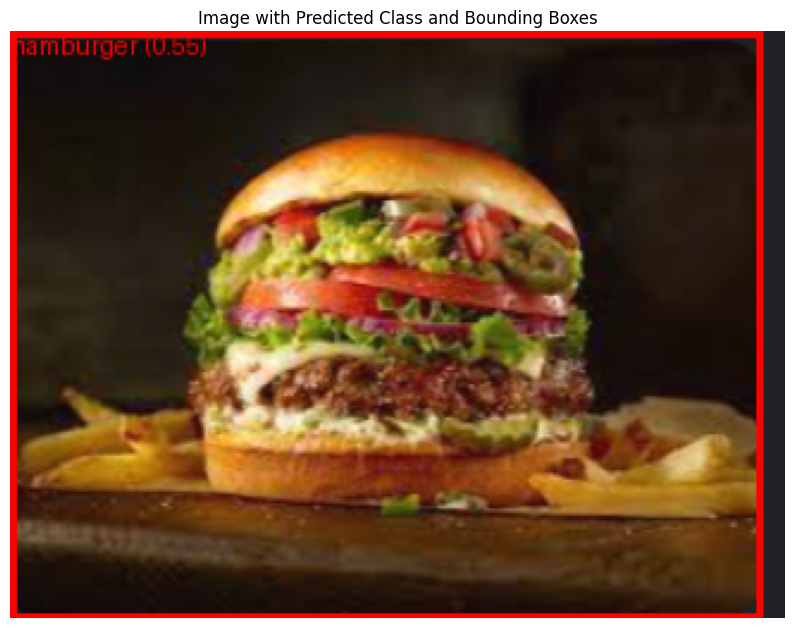

In [13]:
from PIL import ImageDraw

# Load the original image
original_img = Image.open("/kaggle/input/fooood/burger.png")
original_img_draw = original_img.copy()
draw = ImageDraw.Draw(original_img_draw)

# Retrieve predictions from the model
for result in results:
    for box in result.boxes:
        # Extract bounding box, confidence, and class
        x1, y1, x2, y2 = box.xyxy[0]  # Bounding box coordinates
        conf = box.conf[0].item()  # Confidence score
        cls = box.cls[0].item()  # Predicted class index
        label = result.names[int(cls)]  # Class label from the model

        # Draw bounding box and label
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1), f"{label} ({conf:.2f})", fill="red")

# Plot the image with predictions
plt.figure(figsize=(10, 10))
plt.imshow(original_img_draw)
plt.axis("off")
plt.title("Image with Predicted Class and Bounding Boxes")
plt.show()


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\ali\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
model_path = "C:/Users/ali/Downloads/New folder/best (1).pt"  # Update this path
model = YOLO(model_path)

In [2]:
from ultralytics import YOLO

# Define model paths
model1_path = "C:/Users/ali/Downloads/New folder/best (1).pt"
model2_path = "C:/Users/ali/Downloads/New folder/food101_yolov8n_model.pt"
image_path = "C:/Users/ali/Downloads/Falafel-16.jpg"

# Load the first model
model = YOLO(model1_path)

# Run inference on the image
results = model(image_path, save=True, show=True)

# Extract detected food names and confidence scores
detected_foods = []
max_confidence = 0  # Track highest confidence

for r in results:
    for box in r.boxes.data:
        conf = float(box[4])  # Confidence score
        class_id = int(box[5])  # Class ID
        food_name = model.names[class_id]  # Get food name
        detected_foods.append((food_name, conf))  # Store with confidence
        max_confidence = max(max_confidence, conf)  # Update max confidence

# If detection confidence is below 60%, use the second model
if not detected_foods or max_confidence < 0.6:
    print("Low confidence detected. Switching to the second model...")
    model = YOLO(model2_path)

    # Run inference again
    results = model(image_path, save=True, show=True)

    # Extract food names again
    detected_foods = []
    max_confidence = 0

    for r in results:
        for box in r.boxes.data:
            conf = float(box[4])  # Confidence score
            class_id = int(box[5])  # Class ID
            food_name = model.names[class_id]
            detected_foods.append((food_name, conf))
            max_confidence = max(max_confidence, conf)

# Output detected food with highest confidence
if detected_foods:
    food_item, confidence = max(detected_foods, key=lambda x: x[1])  # Select the highest confidence result
    print(f"Detected Food: {food_item} (Confidence: {confidence:.2f})")
else:
    print("No food detected.")



image 1/1 C:\Users\ali\Downloads\Falafel-16.jpg: 512x512 1 falafel, 140.4ms
Speed: 4.6ms preprocess, 140.4ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\detect\predict24
Detected Food: falafel (Confidence: 1.00)


In [7]:
import requests

# Nutritionix API credentials
APP_ID = "beeae400"
APP_KEY = "a119ce8afb23f7a1f518ce7175161e9d"

# Nutritionix API endpoint
NUTRITIONIX_URL = "https://trackapi.nutritionix.com/v2/natural/nutrients"

# Function to get nutrition facts from Nutritionix
def get_nutrition_info(food_item, portion_size_grams):
    headers = {
        "x-app-id": APP_ID,
        "x-app-key": APP_KEY,
        "Content-Type": "application/json",
    }
    data = {
        "query": f"{portion_size_grams}g of {food_item}",
    }
    response = requests.post(NUTRITIONIX_URL, headers=headers, json=data)
    
    if response.status_code == 200:
        food_data = response.json()["foods"][0]
        
        # Extracting all available nutrition information
        nutrients = {
            "Calories": food_data.get("nf_calories", "N/A"),
            "Protein (g)": food_data.get("nf_protein", "N/A"),
            "Total Fat (g)": food_data.get("nf_total_fat", "N/A"),
            "Saturated Fat (g)": food_data.get("nf_saturated_fat", "N/A"),
            "Cholesterol (mg)": food_data.get("nf_cholesterol", "N/A"),
            "Sodium (mg)": food_data.get("nf_sodium", "N/A"),
            "Total Carbohydrates (g)": food_data.get("nf_total_carbohydrate", "N/A"),
            "Dietary Fiber (g)": food_data.get("nf_dietary_fiber", "N/A"),
            "Sugars (g)": food_data.get("nf_sugars", "N/A"),
            "Potassium (mg)": food_data.get("nf_potassium", "N/A"),
        }

        print(f"Nutrition facts for {portion_size_grams}g of {food_item}:")
        for nutrient, value in nutrients.items():
            print(f"{nutrient}: {value}")

        return nutrients
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

# Example: Detected food items and portion sizes (manually provided by the user)
detected_foods = [
    {"category": "pizza", "portion_size_grams": 200},  # 200g of pizza
    {"category": "rice", "portion_size_grams": 150},   # 150g of rice
]

# Retrieve and display nutrition information for each food item
for food in detected_foods:
    category = food["category"]
    portion_size = food["portion_size_grams"]
    get_nutrition_info(category, portion_size)


Nutrition facts for 200g of pizza:
Calories: 532
Protein (g): 22.78
Total Fat (g): 19.38
Saturated Fat (g): 8.93
Cholesterol (mg): 34
Sodium (mg): 1196
Total Carbohydrates (g): 66.66
Dietary Fiber (g): 4.6
Sugars (g): 7.16
Potassium (mg): 344
Nutrition facts for 150g of rice:
Calories: 195
Protein (g): 4.04
Total Fat (g): 0.42
Saturated Fat (g): 0.12
Cholesterol (mg): 0
Sodium (mg): 1.5
Total Carbohydrates (g): 42.26
Dietary Fiber (g): 0.6
Sugars (g): 0.08
Potassium (mg): 52.5


In [9]:
cal=get_nutrition_info(food_item, 100)

Nutrition facts for 100g of falafel:
Calories: 416.12
Protein (g): 5.37
Total Fat (g): 36.57
Saturated Fat (g): 2.44
Cholesterol (mg): 0
Sodium (mg): 151.25
Total Carbohydrates (g): 18.62
Dietary Fiber (g): 4.52
Sugars (g): 3.01
Potassium (mg): 196.78


In [4]:
import cv2
import torch
from ultralytics import YOLO
import requests

# Define model paths
model1_path = "C:/Users/ali/Downloads/New folder/best (1).pt"
model2_path = "C:/Users/ali/Downloads/New folder/food101_yolov8n_model.pt"
image_path = "C:/Users/ali/Downloads/images (1).jpg"

# Nutritionix API Credentials
APP_ID = "beeae400"
APP_KEY = "a119ce8afb23f7a1f518ce7175161e9d"
NUTRITIONIX_URL = "https://trackapi.nutritionix.com/v2/natural/nutrients"

def get_calories(food_item, portion_size_grams=100):
    """Fetch nutrition details from Nutritionix API"""
    headers = {
        "x-app-id": APP_ID,
        "x-app-key": APP_KEY,
        "Content-Type": "application/json",
    }
    data = {"query": f"{portion_size_grams}g of {food_item}"}
    response = requests.post(NUTRITIONIX_URL, headers=headers, json=data)
    
    if response.status_code == 200:
        food_data = response.json()["foods"][0]
        return {
            "calories": food_data.get("nf_calories", "N/A"),
            "protein": food_data.get("nf_protein", "N/A"),
            "fat": food_data.get("nf_total_fat", "N/A"),
            "carbs": food_data.get("nf_total_carbohydrate", "N/A"),
        }
    else:
        print(f"Error fetching data for {food_item}")
        return None

# Load the first model
model = YOLO(model1_path)

# Run inference on the image
results = model(image_path, save=True, show=True)

# Extract detected food names and confidence scores
detected_foods = []
max_confidence = 0  # Track highest confidence

for r in results:
    for box in r.boxes.data:
        conf = float(box[4])  # Confidence score
        class_id = int(box[5])  # Class ID
        food_name = model.names[class_id]  # Get food name
        detected_foods.append({"name": food_name, "confidence": conf, "portion_size": 100})  # Assume 100g portion
        max_confidence = max(max_confidence, conf)  # Update max confidence

# If detection confidence is below 60%, use the second model
if not detected_foods or max_confidence < 0.75:
    print("Low confidence detected. Switching to the second model...")
    model = YOLO(model2_path)

    # Run inference again
    results = model(image_path, save=True, show=True)

    # Extract food names again
    detected_foods = []
    max_confidence = 0

    for r in results:
        for box in r.boxes.data:
            conf = float(box[4])  # Confidence score
            class_id = int(box[5])  # Class ID
            food_name = model.names[class_id]
            detected_foods.append({"name": food_name, "confidence": conf, "portion_size": 100})  # Assume 100g portion
            max_confidence = max(max_confidence, conf)

# Get nutrition info for each detected food item
total_calories = 0
if detected_foods:
    print("\nDetected Foods and Nutrition Information:\n")
    for food in detected_foods:
        nutrition = get_calories(food["name"], food["portion_size"])
        if nutrition:
            total_calories += nutrition["calories"]
            print(f"{food['name']} ({food['portion_size']}g) - "
                  f"Calories: {nutrition['calories']}, "
                  f"Protein: {nutrition['protein']}g, "
                  f"Fat: {nutrition['fat']}g, "
                  f"Carbs: {nutrition['carbs']}g")
else:
    print("No food detected.")

print(f"\nTotal Estimated Calories: {total_calories:.2f} kcal")



image 1/1 C:\Users\ali\Downloads\images (1).jpg: 352x512 1 pulled_pork_sandwich, 50.2ms
Speed: 1.4ms preprocess, 50.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs\detect\predict40
Low confidence detected. Switching to the second model...

image 1/1 C:\Users\ali\Downloads\images (1).jpg: 352x512 1 Shawarma, 41.3ms
Speed: 1.7ms preprocess, 41.3ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 512)
Results saved to runs\detect\predict41

Detected Foods and Nutrition Information:



SSLError: HTTPSConnectionPool(host='trackapi.nutritionix.com', port=443): Max retries exceeded with url: /v2/natural/nutrients (Caused by SSLError(SSLError(1, '[SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED] unsafe legacy renegotiation disabled (_ssl.c:1028)')))